In [31]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


In [32]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

In [66]:
X_dim

784

In [33]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [34]:
# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [35]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


In [37]:
# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0
Loss: 768.8

Iter: 1000
Loss: 147.4

Iter: 2000
Loss: 128.2

Iter: 3000
Loss: 113.3

Iter: 4000
Loss: 120.5

Iter: 5000
Loss: 110.4

Iter: 6000
Loss: 113.8

Iter: 7000
Loss: 116.2

Iter: 8000
Loss: 111.9

Iter: 9000
Loss: 107.7

Iter: 10000
Loss: 104.6

Iter: 11000
Loss: 108.4

Iter: 12000
Loss: 110.2

Iter: 13000
Loss: 102.5

Iter: 14000
Loss: 114.4

Iter: 15000
Loss: 103.2

Iter: 16000
Loss: 109.7

Iter: 17000
Loss: 110.5

Iter: 18000
Loss: 113.2

Iter: 19000
Loss: 107.4

Iter: 20000
Loss: 105.0

Iter: 21000
Loss: 109.0

Iter: 22000
Loss: 108.6

Iter: 23000
Loss: 111.6

Iter: 24000
Loss: 106.0

Iter: 25000
Loss: 114.0

Iter: 26000
Loss: 108.6

Iter: 27000
Loss: 110.5

Iter: 28000
Loss: 109.6

Iter: 29000
Loss: 106.9

Iter: 30000
Loss: 104.8

Iter: 31000
Loss: 106.5

Iter: 32000
Loss: 108.8

Iter: 33000
Loss: 110.6

Iter: 34000
Loss: 105.1

Iter: 35000
Loss: 105.2

Iter: 36000
Loss: 99.35

Iter: 37000
Loss: 105.1

Iter: 38000
Loss: 106.2

Iter: 39000
Loss: 105.3

Iter: 40000
L

Iter: 320000
Loss: 103.5

Iter: 321000
Loss: 103.6

Iter: 322000
Loss: 105.9

Iter: 323000
Loss: 108.1

Iter: 324000
Loss: 106.3

Iter: 325000
Loss: 102.1

Iter: 326000
Loss: 113.1

Iter: 327000
Loss: 104.8

Iter: 328000
Loss: 100.7

Iter: 329000
Loss: 107.3

Iter: 330000
Loss: 106.0

Iter: 331000
Loss: 102.3

Iter: 332000
Loss: 104.8

Iter: 333000
Loss: 104.7

Iter: 334000
Loss: 102.2

Iter: 335000
Loss: 108.7

Iter: 336000
Loss: 105.8

Iter: 337000
Loss: 103.5

Iter: 338000
Loss: 112.5

Iter: 339000
Loss: 105.6

Iter: 340000
Loss: 107.8

Iter: 341000
Loss: 102.1

Iter: 342000
Loss: 107.0

Iter: 343000
Loss: 110.2

Iter: 344000
Loss: 101.3

Iter: 345000
Loss: 104.0

Iter: 346000
Loss: 107.1

Iter: 347000
Loss: 105.0

Iter: 348000
Loss: 106.7

Iter: 349000
Loss: 110.0

Iter: 350000
Loss: 106.7

Iter: 351000
Loss: 108.5

Iter: 352000
Loss: 106.9

Iter: 353000
Loss: 107.8

Iter: 354000
Loss: 99.53

Iter: 355000
Loss: 104.4

Iter: 356000
Loss: 111.4

Iter: 357000
Loss: 104.6

Iter: 358000

Iter: 636000
Loss: 103.5

Iter: 637000
Loss: 108.9

Iter: 638000
Loss: 97.78

Iter: 639000
Loss: 106.5

Iter: 640000
Loss: 102.8

Iter: 641000
Loss: 106.4

Iter: 642000
Loss: 107.2

Iter: 643000
Loss: 104.5

Iter: 644000
Loss: 98.58

Iter: 645000
Loss: 100.0

Iter: 646000
Loss: 100.3

Iter: 647000
Loss: 105.7

Iter: 648000
Loss: 105.6

Iter: 649000
Loss: 101.7

Iter: 650000
Loss: 103.1

Iter: 651000
Loss: 101.0

Iter: 652000
Loss: 108.0

Iter: 653000
Loss: 98.73

Iter: 654000
Loss: 103.0

Iter: 655000
Loss: 104.1

Iter: 656000
Loss: 97.5

Iter: 657000
Loss: 106.3

Iter: 658000
Loss: 101.8

Iter: 659000
Loss: 107.8

Iter: 660000
Loss: 102.1

Iter: 661000
Loss: 106.8

Iter: 662000
Loss: 103.6

Iter: 663000
Loss: 104.9

Iter: 664000
Loss: 101.6

Iter: 665000
Loss: 105.7

Iter: 666000
Loss: 105.5

Iter: 667000
Loss: 100.6

Iter: 668000
Loss: 98.78

Iter: 669000
Loss: 98.01

Iter: 670000
Loss: 101.1

Iter: 671000
Loss: 114.0

Iter: 672000
Loss: 101.8

Iter: 673000
Loss: 101.5

Iter: 674000


Iter: 952000
Loss: 104.6

Iter: 953000
Loss: 97.43

Iter: 954000
Loss: 104.1

Iter: 955000
Loss: 105.4

Iter: 956000
Loss: 105.0

Iter: 957000
Loss: 96.61

Iter: 958000
Loss: 105.0

Iter: 959000
Loss: 102.9

Iter: 960000
Loss: 107.7

Iter: 961000
Loss: 105.3

Iter: 962000
Loss: 110.0

Iter: 963000
Loss: 102.7

Iter: 964000
Loss: 105.8

Iter: 965000
Loss: 109.5

Iter: 966000
Loss: 110.0

Iter: 967000
Loss: 106.1

Iter: 968000
Loss: 101.4

Iter: 969000
Loss: 101.9

Iter: 970000
Loss: 106.8

Iter: 971000
Loss: 99.38

Iter: 972000
Loss: 98.72

Iter: 973000
Loss: 108.3

Iter: 974000
Loss: 100.0

Iter: 975000
Loss: 100.3

Iter: 976000
Loss: 109.3

Iter: 977000
Loss: 107.8

Iter: 978000
Loss: 108.6

Iter: 979000
Loss: 105.7

Iter: 980000
Loss: 109.6

Iter: 981000
Loss: 103.0

Iter: 982000
Loss: 103.5

Iter: 983000
Loss: 103.4

Iter: 984000
Loss: 110.3

Iter: 985000
Loss: 105.5

Iter: 986000
Loss: 102.1

Iter: 987000
Loss: 101.0

Iter: 988000
Loss: 100.9

Iter: 989000
Loss: 98.24

Iter: 990000

In [55]:

X = mnist.train.images
y = mnist.train.labels
X.shape, y.shape

((55000, 784), (55000, 10))

In [92]:
number1 = 1
labels = [np.where(r==1)[0][0] for r in y]
index = labels.index(number1)
image_number1 = X[index]
image_number1 = np.transpose(image_number1.reshape(image_number1.shape[0],1))
image_number1.shape

(1, 784)

In [93]:
#X_mb, _ = mnist.train.next_batch(1)
#X_mb.shape

In [94]:
z_mu, z_logvar = Q(image_number1)
z_sample = sample_z(z_mu, z_logvar)
with sess.as_default():
    z_sample = z_sample.eval()
z_sample

array([[ 0.18022622,  0.11077534, -1.094284  ,  1.1319791 ,  0.50938034,
        -0.5040709 ,  0.8125492 , -0.48916164, -0.4226346 ,  0.62865144,
         0.6097791 , -0.36395648, -0.31064215,  0.1728422 , -0.30119678,
         2.525243  ,  0.22336128, -1.4502527 , -0.23703027,  0.3323614 ,
         0.57517296, -2.2133234 ,  1.4147897 ,  0.6763068 ,  1.2355951 ,
        -1.0189474 , -0.2713237 , -1.0292524 ,  1.1564608 ,  1.385259  ,
        -0.25289908,  0.5801509 , -0.20645994, -0.9877954 ,  0.18172318,
        -1.0400393 , -1.286654  ,  1.2817832 ,  0.19097935, -0.88882315,
         0.26128012,  1.3832791 ,  0.72286004,  0.15175255,  0.20844692,
         0.21398568, -0.8896309 , -1.0828973 ,  0.6847708 , -1.2999574 ,
        -0.8603712 ,  0.20279372,  0.44423762,  0.18123682, -0.752697  ,
         0.06093716,  0.7324909 , -0.22800972, -1.0924894 ,  0.31440106,
        -0.48519024, -1.7861592 ,  0.34037697, -0.89288604,  0.04802707,
        -0.42779264,  1.37314   , -0.32669002, -0.6

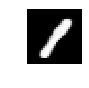

In [96]:
randoms = [np.random.normal(0, 1, z_dim) for _ in range(10)]
# Sampling from random z
X_samples, _ = P(z)
imgs = sess.run(X_samples, feed_dict = {z: z_sample})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

In [42]:
randoms

[array([-1.34560635, -1.4114607 ,  0.81731989,  1.42334598, -0.21288635,
        -0.59446968, -0.02313693, -0.397687  , -2.03747294,  0.4168508 ,
         2.135997  ,  2.19635066, -0.29058471, -0.36188943, -1.49710914,
        -0.1763908 ,  0.38673402, -1.34154168, -0.15453601,  0.24938872,
        -1.64865146,  1.08056544, -0.68090588,  0.2277199 ,  0.66434737,
        -0.8315589 ,  1.54600496, -0.85707639, -0.82262121,  0.96970225,
         1.68516885, -0.08423674, -1.56256933,  0.94142515,  0.49665363,
         1.98388884, -0.78239279, -0.76526621,  1.16814929,  0.0252247 ,
        -0.19885691,  0.81242925, -0.32756229,  0.77282984,  0.42331543,
        -0.00965402,  0.9808392 ,  0.39830581,  0.67108785,  0.8904183 ,
         0.48614626, -0.17321265, -0.54843818,  0.57729871, -0.26428821,
         1.33585694, -0.08036467, -0.49309852,  1.4175031 , -0.85400583,
         0.33371261,  0.73210172,  1.33972833, -0.1512734 ,  0.36974766,
         0.91363675, -0.65855876, -0.64900288,  2.0